### 1. Importation des bibliothèques nécessaires

In [119]:
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


### 2. Chargement des donées


In [120]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')


train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28855 entries, 0 to 28854
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28855 non-null  int64  
 1   date          28855 non-null  float64
 2   hour          28855 non-null  float64
 3   bc_price      28855 non-null  float64
 4   bc_demand     28855 non-null  float64
 5   ab_price      28855 non-null  float64
 6   ab_demand     28855 non-null  float64
 7   transfer      28855 non-null  float64
 8   bc_price_evo  28855 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 2.0+ MB


### 3. Traitement préliminaires des données chargées:

In [121]:
# Droppping unnecessary columns
X_train = train_df.drop(columns=['id', 'bc_price_evo'])
Y_train = train_df['bc_price_evo']

X_test = test_df.drop(columns=['id'])


# Normalisation:
X_train = X_train / X_train.std() - X_train.mean()
X_test = X_test / X_train.std() - X_train.mean()

# Replacing UP and DOWN classing to 1 and 0
Y_train = Y_train.replace({'UP': 1, 'DOWN': 0})

Y_train.info()
X_train.info()


<class 'pandas.core.series.Series'>
RangeIndex: 28855 entries, 0 to 28854
Series name: bc_price_evo
Non-Null Count  Dtype
--------------  -----
28855 non-null  int64
dtypes: int64(1)
memory usage: 225.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28855 entries, 0 to 28854
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       28855 non-null  float64
 1   hour       28855 non-null  float64
 2   bc_price   28855 non-null  float64
 3   bc_demand  28855 non-null  float64
 4   ab_price   28855 non-null  float64
 5   ab_demand  28855 non-null  float64
 6   transfer   28855 non-null  float64
dtypes: float64(7)
memory usage: 1.5 MB


/tmp/ipykernel_26061/1424665077.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = Y_train.replace({'UP': 1, 'DOWN': 0})


### 4. Spliting the data:

In [122]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

### 5. Creating Dataset:

In [123]:
class ElectricityDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.Y = torch.tensor(Y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
train_dataset = ElectricityDataset(X_train, Y_train)
val_dataset = ElectricityDataset(X_val, Y_val)


### 6. Creating the model:

In [124]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputDim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(inputDim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1) # no softmax because we will use BinaryCrossEntropyLoss
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

    def __str__(self):
        return f"{self.model}"
        

### 7 Definitions of metrics, model, loss, etc.

In [125]:


LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 100
WEIGHT_DECAY = 1e-4

inputDim = len(X_train.columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = input("Wanna load a model ? (give its name)")
if model_name == "":
    model_name = "lastModel"
    
try:
    model = torch.load("./models/" + model_name + ".pth")
    print(f"Model {model_name} loaded")

except FileNotFoundError:
    print("No model found, creating a new one")
    model = NeuralNetwork(inputDim).to(device)
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.BCEWithLogitsLoss()


No model found, creating a new one


### 8. DataLoaders:

In [126]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 9. Training function:

In [ ]:
def train(model, train_loader, val_loader, epochs, optimizer, criterion, device):

    training_accruacies_epoch = []
    validation_accruacies_epoch = []
    training_losses_epoch = []
    validation_losses_epoch = []

    for epoch in range(epochs):
                
        #############################
        ########## TRAINING #########
        #############################
        
        model.train(True)
        
        # Metrics:
        running_training_loss = 0.0
        correct_guess_training = 0
        total_training = 0
        
        
        for i, data in enumerate(train_loader):
            inputs, labels = data
            
            # Moving to the device:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = criterion(outputs.squeeze(), labels)
            loss.backward() # compute gradients

            # Adjust learning weights
            optimizer.step()

            # Update metrics:
            running_training_loss += loss.item()
            correct_guess_training += ((outputs > 0.5).float() == labels).sum().item() 
            total_training += labels.size(0)


        # Accuracy:
        training_accuracy = correct_guess_training / total_training
        avg_training_loss = running_training_loss / (i + 1)

        #############################
        ######## VALIDATION #########
        #############################

        running_vloss = 0.0
        correct_guess_validation = 0
        total_validation = 0
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs.squeeze(), vlabels)
                running_vloss += vloss
                
                correct_guess_validation += ((voutputs > 0.5).float() == vlabels).sum().item()
                total_validation += vlabels.size(0)
                
        # Accuracy:
        validation_accuracy = correct_guess_validation / total_validation
        avg_vloss = running_vloss / (i + 1)

        

        # Print the results for this epoch
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Training Loss: {avg_training_loss:.4f} - "
              f"Training Accuracy: {training_accuracy:.4f} % - "
              f"Validation Loss: {avg_vloss:.4f} - "
              f"Validation Accuracy: {validation_accuracy:.4f} %")
        
        # Save the metrics for plotting
        training_accruacies_epoch.append(training_accuracy)
        validation_accruacies_epoch.append(validation_accuracy)
        training_losses_epoch.append(avg_training_loss)
        validation_losses_epoch.append(avg_vloss)
        
    return model, training_accruacies_epoch, validation_accruacies_epoch, training_losses_epoch, validation_losses_epoch



### 10. Training the model:

In [ ]:
information_writing_string = f"""Starting training:
\t - Model: {model_name}
\t - Learning rate: {LR}
\t - Batch size: {BATCH_SIZE}
\t - Epochs: {EPOCHS}
\t - Weight decay: {WEIGHT_DECAY}
\t - Device: {device} \n"""

# Create the file:
    

with open("./infos/info" + model_name + ".txt", 'w') as f:
    f.write(information_writing_string)
    f.close()

model, training_accruacies_epoch, validation_accruacies_epoch, training_losses_epoch, validation_losses_epoch = train(
    model, train_loader, val_loader, EPOCHS, optimizer, criterion, device
)

Epoch 1/100 - Training Loss: 0.5381 - Training Accuracy: 64.3712 - Validation Loss: 0.5499 - Validation Accuracy: 64.0352
Epoch 2/100 - Training Loss: 0.4934 - Training Accuracy: 64.2309 - Validation Loss: 0.4913 - Validation Accuracy: 63.9948
Epoch 3/100 - Training Loss: 0.4843 - Training Accuracy: 64.1486 - Validation Loss: 0.4846 - Validation Accuracy: 64.0121
Epoch 4/100 - Training Loss: 0.4814 - Training Accuracy: 64.2108 - Validation Loss: 0.4800 - Validation Accuracy: 63.9837
Epoch 5/100 - Training Loss: 0.4779 - Training Accuracy: 64.1560 - Validation Loss: 0.4803 - Validation Accuracy: 63.9442
Epoch 6/100 - Training Loss: 0.4768 - Training Accuracy: 64.1100 - Validation Loss: 0.4819 - Validation Accuracy: 64.0166
Epoch 7/100 - Training Loss: 0.4749 - Training Accuracy: 64.1240 - Validation Loss: 0.4804 - Validation Accuracy: 64.0014
Epoch 8/100 - Training Loss: 0.4735 - Training Accuracy: 64.1830 - Validation Loss: 0.4738 - Validation Accuracy: 63.9515
Epoch 9/100 - Training L

### 11. Metrics and saving:

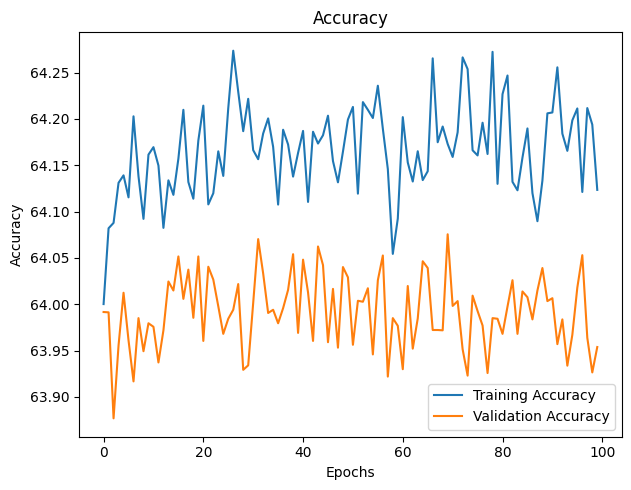

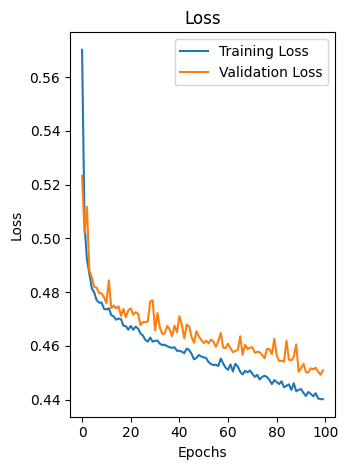

RuntimeError: Parent directory ./models does not exist.

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_accruacies_epoch, label='Training Accuracy')
plt.plot(validation_accruacies_epoch, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(training_losses_epoch, label='Training Loss')
plt.plot(validation_losses_epoch, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), "./models/" + model_name + ".pth")